Create a two-panel figure with the zeroth moment maps.

Given the nature of the paper, I plan on keeping the units in K km/s.

In [1]:
%matplotlib inline

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import os
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import Projection
from scipy import ndimage as nd
from astropy.stats import histogram as astro_hist
from tqdm import tqdm
from corner import hist2d

from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
# from radio_beam import Beam
from astropy.wcs.utils import proj_plane_pixel_area

osjoin = os.path.join

repo_path = os.path.expanduser("~/ownCloud/project_code/ThickHIFitting/")

figures_path_png = osjoin(repo_path, "figures/png")
figures_path_pdf = osjoin(repo_path, "figures/pdf")


def save_figure(fig, plot_name):
    fig.savefig(f"{figures_path_pdf}/{plot_name}.pdf")
    fig.savefig(f"{figures_path_png}/{plot_name}.png")


paths_script = os.path.join(repo_path, "paths.py")
exec(compile(open(paths_script, "rb").read(), paths_script, 'exec'))

plotstyle_script = os.path.join(repo_path, "plotting_styles.py")
exec(compile(open(plotstyle_script, "rb").read(), plotstyle_script, 'exec'))



In [2]:
# M31

m31_cube = SpectralCube.read(fifteenA_HI_BCtaper_wEBHIS_HI_file_dict['Cube'])
print(f'Opening cube {fifteenA_HI_BCtaper_wEBHIS_HI_file_dict["Cube"]}')

m31_vels = m31_cube.spectral_axis.to(u.m / u.s)
      
del m31_cube

m31_mom0 = Projection.from_hdu(fits.open(fifteenA_HI_BCtaper_wEBHIS_HI_file_dict['Moment0'])).to(u.K * u.km / u.s)

# Make custom slice so the array shapes are roughly the same in M33 and M31
spat_slice_zoom_m31 = (slice(105, 1709), slice(347, 1603))

Opening cube /mnt/bigdata/ekoch/M31/VLA/15A-175/HI/full_imaging_BCD_taper_0_42kms_wEBHIS/M31_15A_B_C_14A_HI_contsub_width_0_4kms.image.pbcor.EBHIS_feathered.fits


In [3]:
# M33

cube_name = fourteenB_HI_data_wGBT_path("M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked.fits")

downsamp_cube_name = f"{cube_name.rstrip('.fits')}_0p42kms_K.fits"
        
m33_cube = SpectralCube.read(downsamp_cube_name)
print(f'Opening cube {downsamp_cube_name}')

m33_vels = m33_cube.spectral_axis.to(u.m / u.s)
      
del m33_cube

m33_mom0_name = "M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked.moment0_Kkms.fits"
m33_mom0 = Projection.from_hdu(fits.open(fourteenB_HI_data_wGBT_path(m33_mom0_name))).to(u.K * u.km / u.s)

# Slice out to zoom into the valid data region.
spat_slice_zoom_m33 = (slice(None), slice(None))

Opening cube /mnt/bigdata/ekoch/M33/VLA/14B-088/HI/full_imaging_wGBT/M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked_0p42kms_K.fits


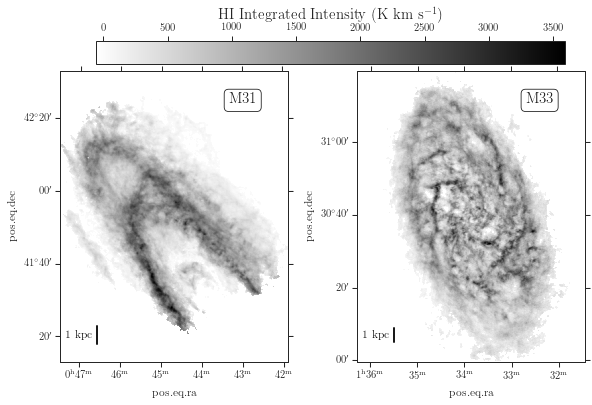

In [4]:
twocolumn_figure(font_scale=1.2)

import matplotlib.colors as colors

vmin = 0
vmax = 3600

# norm = colors.SymLogNorm(linthresh=100., linscale=0.2,
#                          vmin=vmin, vmax=vmax)

fig = plt.figure()

ax = fig.add_subplot(121, projection=m31_mom0[spat_slice_zoom_m31].wcs)

im = ax.imshow(m31_mom0[spat_slice_zoom_m31].value, # vmin=vmin, vmax=vmax,
               cmap=plt.cm.binary,
               alpha=1.)

ax2 = fig.add_subplot(122, projection=m33_mom0[spat_slice_zoom_m33].wcs)

# Scale to the 95% in image
# vmin, vmax = np.nanpercentile(diff_bic_zoom_m33, [2.5, 97.5])

im2 = ax2.imshow(m33_mom0[spat_slice_zoom_m33].value, # vmin=vmin, vmax=vmax,
               cmap=plt.cm.binary,
               alpha=1.)

cbar = fig.colorbar(im, ax=[ax, ax2], location='top')

cbar.set_label(r"HI Integrated Intensity (K km s$^{-1}$)", fontsize=15)

xp = 0.8
yp = 0.9

bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

ax.text(xp, yp, "M31", transform=ax.transAxes,
        horizontalalignment='center',
        verticalalignment='center',
        bbox=bbox_props, fontsize=15)

ax2.text(xp, yp, "M33", transform=ax2.transAxes,
         horizontalalignment='center',
         verticalalignment='center',
         bbox=bbox_props, fontsize=15)


# Add scale bars

# M31
length = (1. * u.kpc / (720 * u.kpc)).to(u.deg, u.dimensionless_angles())
length_pix = length.value / np.abs(m33_mom0.header['CDELT2'])
ax.plot([200, 200], [150 - length_pix / 2., 150 + length_pix / 2.], 'k',
        linewidth=2)
ax.text(200 - 20, 150,
        "1 kpc", color='k', va='center', ha='right')

# M33
length = (1. * u.kpc / (840 * u.kpc)).to(u.deg, u.dimensionless_angles())
length_pix = length.value / np.abs(m33_mom0.header['CDELT2'])
ax2.plot([200, 200], [150 - length_pix / 2., 150 + length_pix / 2.], 'k',
        linewidth=2)
ax2.text(200 - 20, 150,
        "1 kpc", color='k', va='center', ha='right')

fig.subplots_adjust(right=0.95, left=0.05, bottom=0.05, top=0.75)

save_figure(fig, 'm31_m33_integratedintensity_map')

In [5]:
np.nanmax(m31_mom0)

<Projection 3590.72185449 K km / s>

In [6]:
np.nanmax(m33_mom0)

<Projection 1338.91297165 K km / s>

In [7]:
m31_mom0.beam

Beam: BMAJ=17.887733459472656 arcsec BMIN=15.57705307006836 arcsec BPA=75.21550158527786 deg

In [8]:
m33_mom0.beam

Beam: BMAJ=18.98463225446057 arcsec BMIN=17.047559616101886 arcsec BPA=-81.81218585468574 deg

In [9]:
m33_mom0.beam.major.to(u.arcsec).value * 4 * u.pc

<Quantity 75.93852902 pc>

M33's inclination is ~55 degree. So along the minor axis, the scale is:

In [11]:
m33_mom0.beam.major.to(u.arcsec).value * 4 * u.pc / np.cos(55 * u.deg)

<Quantity 132.39478508 pc>

In [12]:
m31_mom0.beam.major.to(u.arcsec).value * 4 * u.pc * (720. / 840.)

<Quantity 61.32937186 pc>

And along the the minor axis:

In [13]:
m31_mom0.beam.major.to(u.arcsec).value * 4 * u.pc * (720. / 840.) / np.cos(78 * u.deg)

<Quantity 294.97798618 pc>